In [3]:
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os

import threading

In [4]:
def plot_cwnd_vs_time(noOfSources = 2):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    for i in range(noOfSources):
        cwndvstime = {}
    
        with open(f"/mnt/Store/Project-summer/runtime/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        plt.plot(cwndvstime.keys(), cwndvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("cwnd")
    plt.title("Congestion windows size vs time ")
    f.close()

In [89]:
def plot_dropped_vs_time():
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/droppedPacketTrace.txt", "r") as f:
        lines = f.readlines()
        prev = 0;
        total_dropped = 0;
        bin = 0;
        for line in lines:
            split_line = line.split()
            
            if ( float(split_line[0]) - prev < 0.1) :
                bin = bin+1;
            else:
                droppedpvstime[prev] = bin;
                prev = float(split_line[0]);
                bin = 0;

    
    plt.plot(droppedpvstime.keys(), droppedpvstime.values())
    
    plt.xlabel("time")
    plt.ylabel("Packet Dropped")
    plt.title("Packet Dropped vs time ")
    f.close()


In [90]:
def plot_qsize_vs_time():
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/qsizeTrace.txt", "r") as f:
        lines = f.readlines()
    
    for line in lines:
        split_line = line.split()
        if ( len(split_line) == 1):
            max_size = split_line[0][0:-1]
            continue;
        qutilvstime[float(split_line[0])] = (float(split_line[1])/float(max_size))*100;

    
    plt.plot(qutilvstime.keys(), qutilvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("Q utilization %")
    plt.title("Q utilization vs time ")
    f.close()


In [91]:
def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTT = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTT));

In [92]:
def main(flavour = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth = 100, 
         bottleneck_delay = 1 , RTT = "10ms", packetSize = 1458, queueL = 5, noOfSource = 2, 
         packetPerSource = 10000000, sourceRate = 5, rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0):
    
    # access_link_delay_val = RTT[0:-2]
    access_link_bandwidth_val = total_access_bandwidth[0:-4]
    
    #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
    access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
        
    # if os.path.exists("/mnt/Store/Project-summer/runtime"):
    #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")
        
    cmd = f'''./ns3 run \"scratch/tcp_ftp_n --nSources={noOfSource} 
    --flavour={flavour} --bottleneckBandwidth={bottleneck_bandwidth} 
    --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
    --queueSize={queueL} --pktSize={packetSize} 
    --simDuration={time} --nPackets={packetPerSource} --sourceRate={sourceRate} 
    --rcvBuff={rcvBuff} --sndBuff={sndBuff} --enableBottleneckTrace={enableBottleneckTrace} 
    --RTT={RTT}\"'''
    
    print(cmd)
    os.system(cmd)
    plot_cwnd_vs_time(noOfSource)
    plot_qsize_vs_time()
    plot_dropped_vs_time()
    #clean(flavor = flavor, time = time, queueL = queueL, noOfSource = noOfSource, total_input_bandwidth = total_input_bandwidth, bottleneck_bandwidth= bottleneck_bandwidth, RTT = RTT, recvWindow = recvWindow)   


./ns3 run "scratch/tcp_ftp_n --nSources=2 
    --flavour=TcpNewReno --bottleneckBandwidth=100Mbps 
    --bottleneckDelay=1ms --accessBandwidth=60.0Mbps 
    --queueSize=2084p --pktSize=1500 
    --simDuration=20 --nPackets=10000000 --sourceRate=5 
    --rcvBuff=15000000 --sndBuff=15000000 --enableBottleneckTrace=0 
    --RTT=10ms"
Consolidate compiler generated dependencies of target scratch_tcp_ftp_n


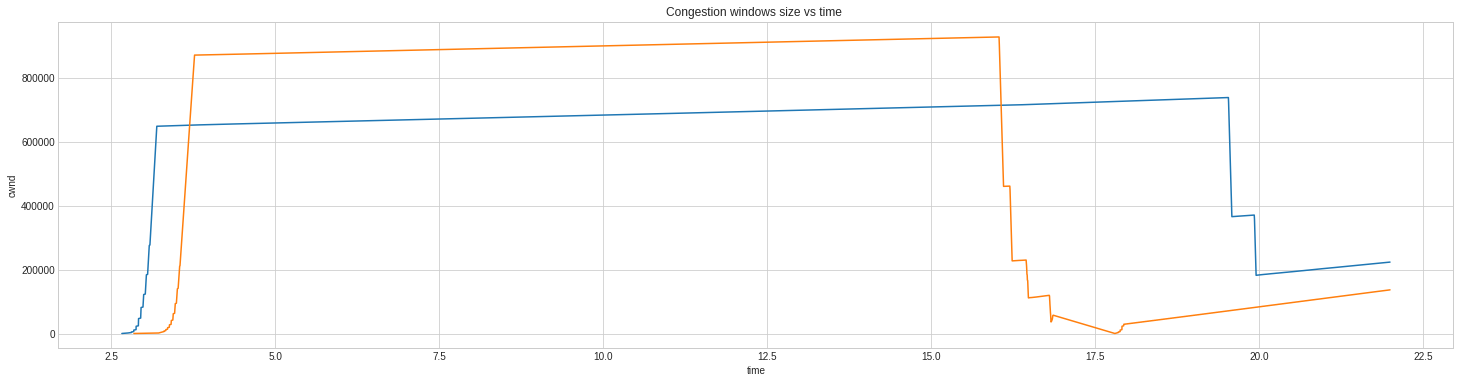

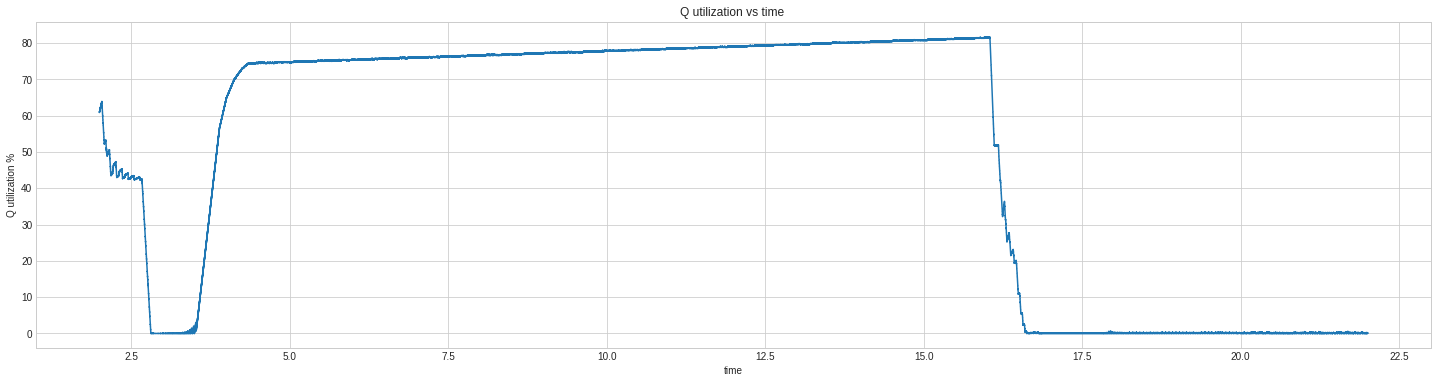

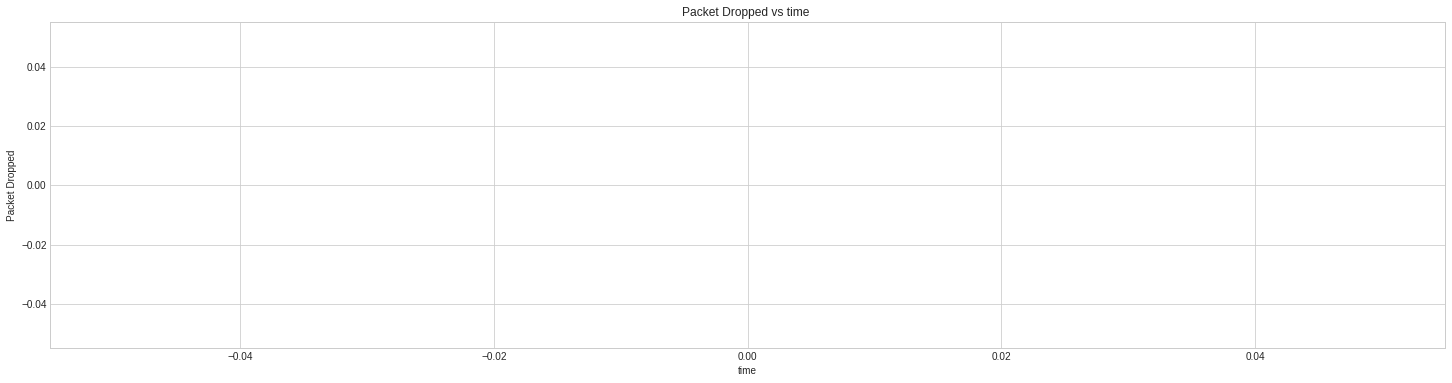

In [94]:
pktSize = 1500
main(flavour = "TcpNewReno", 
     time = 20, 
     noOfSource = 2, 
     total_access_bandwidth = "120Mbps", 
     RTT = "10ms",
     bottleneck_bandwidth = "100Mbps", 
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     rcvBuff = str(pktSize*10000),
     sndBuff = str(pktSize*10000),
     enableBottleneckTrace = 0
     )

./ns3 run "scratch/tcp_ftp_n --nSources=1 
    --flavour=TcpBbr --bottleneckBandwidth=100Mbps 
    --bottleneckDelay=1ms --accessBandwidth=120.0Mbps 
    --queueSize=2084p --pktSize=1500 
    --simDuration=20 --nPackets=10000000 --sourceRate=5 
    --rcvBuff=15000000 --sndBuff=15000000 --enableBottleneckTrace=0 
    --RTT=10ms"


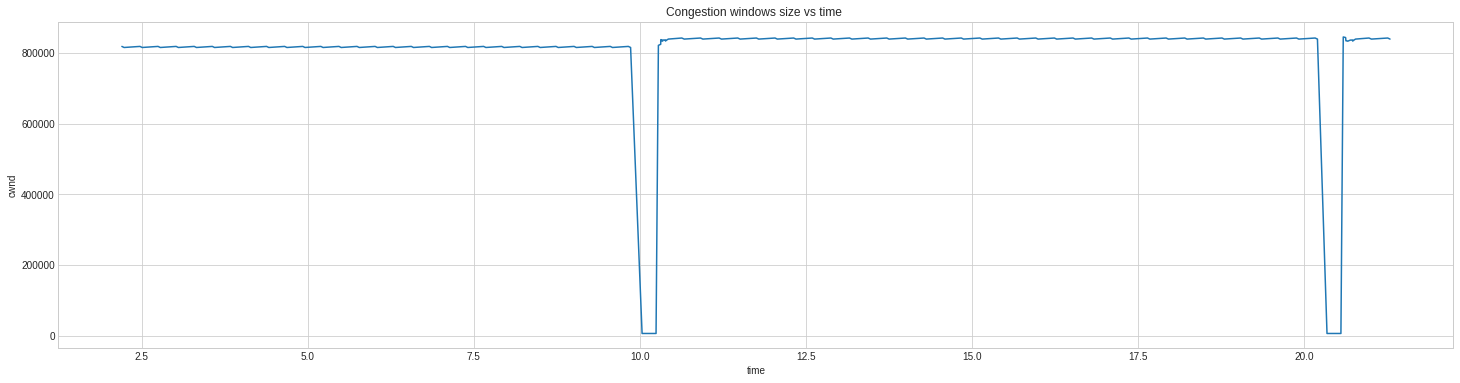

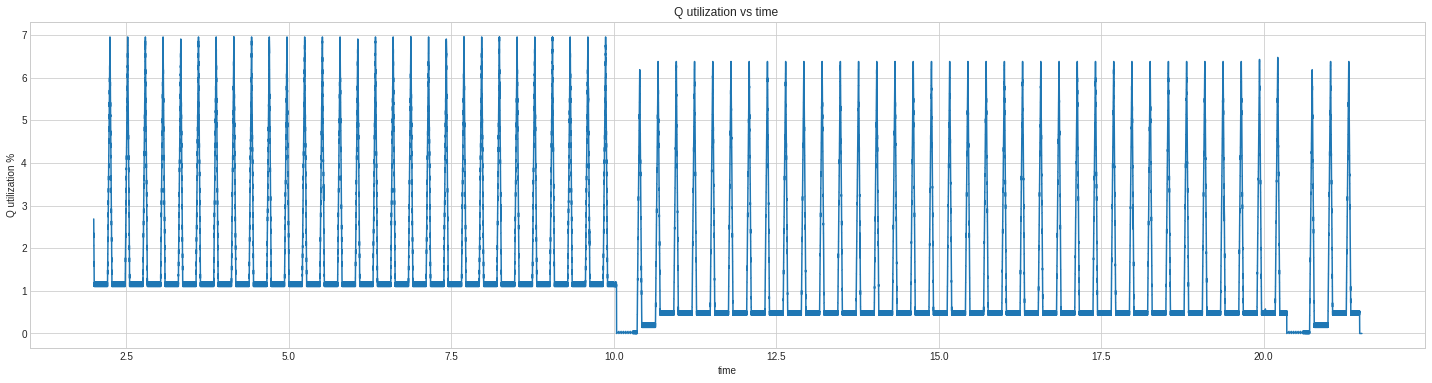

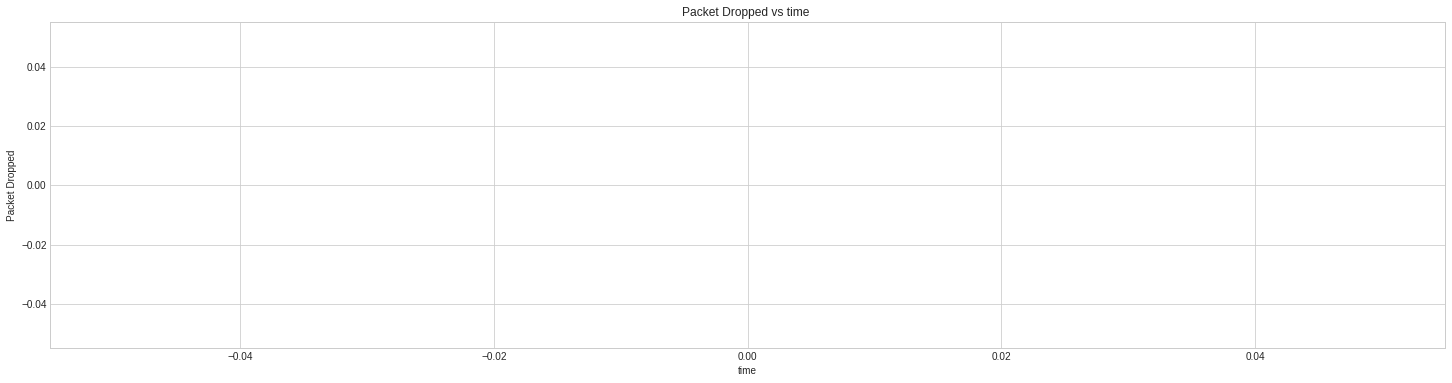

In [95]:
pktSize = 1500
main(flavour = "TcpBbr", 
     time = 20, 
     noOfSource = 1, 
     total_access_bandwidth = "120Mbps", 
     RTT = "10ms",
     bottleneck_bandwidth = "100Mbps", 
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     rcvBuff = str(pktSize*10000),
     sndBuff = str(pktSize*10000),
     enableBottleneckTrace = 0
     )

In [11]:
# # Running multiple simulations

# RTTs = [10, 100, 200]
# sources = [1, 40]

# threads = []

# for rtt in RTTs:
#     for s in sources:
#         threads.append(threading.Thread(target=main, args=("bbr", 20, 2084, s, 120, 100, rtt, 10000)))
        
# for thread in threads:
#     thread.start()

# for thread in threads:
#     thread.join()

In [12]:
#main(flavor = "bbr", time = 20, queueL = 2084, noOfSource = 3, total_input_bandwidth = 120, bottleneck_bandwidth= 120, RTT = 10, recvWindow = 10000)